## Importing Stock Data

In [165]:
import pandas as pd
import requests
import yfinance as yf
import os
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

## How to pull in CUSIP to ticker mapping (NEEDS AUTOMATED)

In [112]:
## Alpha Vantage API Key
## WHB506UEK5KP34ZA

stan = pd.read_csv(r"Holdings_shares\Stanley_Druckenmiller.csv")

mapping1 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker.txt",delimiter="|")
mapping2 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker2.txt",delimiter="|")
mapping3 = pd.read_csv(r"C:\Users\bfass\OneDrive\Desktop\Fin tools\BigMoney13F\Cusip_to_ticker\cusip_to_ticker3.txt",delimiter="|")

mapping = pd.concat([mapping1, mapping2, mapping3]).drop_duplicates()

In [113]:
directory = "Holdings_shares"

# Create an empty dictionary to store DataFrames
dfs = {}

# Iterate through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Construct the full file path
        filepath = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df_name = os.path.splitext(filename)[0]  # Get the file name without the extension

        read_df = pd.read_csv(filepath)
        read_df = read_df.merge(mapping[["CUSIP", "SYMBOL"]].drop_duplicates(), how = 'left', on = "CUSIP")

        dfs[df_name] = read_df


## Uniue symbols used to pull sector
symbols = pd.concat(dfs.values())

symbols.loc[symbols['SYMBOL'] == 'BRKB', 'SYMBOL'] = 'BRK-B'

unique_symbols = symbols[["NAME OF ISSUER", "SYMBOL"]].drop_duplicates()

In [114]:
unique_symbols = unique_symbols[~unique_symbols["SYMBOL"].isnull()]

sectors = []
industries = []

for ticker in unique_symbols["SYMBOL"]:
    #print(ticker)
    data = yf.Ticker(ticker)
    try:
        if data.info["quoteType"] == "ETF":
            try:
                sector = data.info['category']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing 

            industry = "ETF"
        else:
            try:
                sector = data.info['sector']  # Attempt to access sector
            except KeyError:
                sector = "Unknown"  # Assign "Unknown" if sector is missing

            try:
                industry = data.info["industry"]  # Attempt to access industry
            except KeyError:
                industry = "Unknown"  # Assign "Unknown" if industry is missing
    except:
        sector = "Unknown" 
        industry = "Unknown"


    sectors.append(sector)
    industries.append(industry)

unique_symbols["Sector"] = sectors
unique_symbols["Industry"] = industries

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/GBWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=GBWS&crumb=von2BZ7xLEo
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/JWSMWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=JWSMWS&crumb=von2BZ7xLEo
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/FERGXXXX?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=FERGXXXX&crumb=von2BZ7xLEo
404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/NPWRWS?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomai

In [115]:
# Define start and end dates
start_date = "2013-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

# Create a list to store the downloaded dataframes
historical_data = []

for symbol in unique_symbols["SYMBOL"]:
    # Download historical data for the current symbol
    ticker_data = yf.download(symbol, start=start_date, end=end_date)

    # Append the data to the list
    historical_data.append(ticker_data)

# Optionally, concatenate the dataframes into a single DataFrame with a multi-index
historical_data = pd.concat(historical_data, keys=unique_symbols["SYMBOL"], names=["SYMBOL"]).reset_index()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [153]:
holdings_data = {}

for key, df in dfs.items():
    test = df.merge(unique_symbols[['SYMBOL', 'Sector', 'Industry']], on = "SYMBOL", how = 'left')
    
    test.drop(columns = "Unnamed: 0", inplace = True)

    test = test.melt(id_vars=['NAME OF ISSUER', 'CUSIP', 'CALL', 'SYMBOL','Sector', 'Industry'], var_name='Date', value_name='Shares').drop_duplicates()

    test["Date"] = pd.to_datetime(test["Date"])

    test = test.merge(historical_data[["SYMBOL", "Date", "Adj Close"]], on = ["SYMBOL", "Date"], how = "left")

    test["Quarter"] = np.where(test["Date"].dt.month <= 3, "Q4",
                        np.where(test["Date"].dt.month <= 6, "Q1",
                                np.where(test["Date"].dt.month <= 9, "Q2","Q3")))
    
    test["Year"] = test["Date"].dt.year

    test["Year_Quarter"] = np.where(test["Quarter"] == "Q4", (test["Year"]-1).astype(str) + "-" + test["Quarter"], test["Year"].astype(str) + "-" + test["Quarter"])

    test["Position Value"] = test["Adj Close"] *  test["Shares"]

    

    holdings_data[key] = test

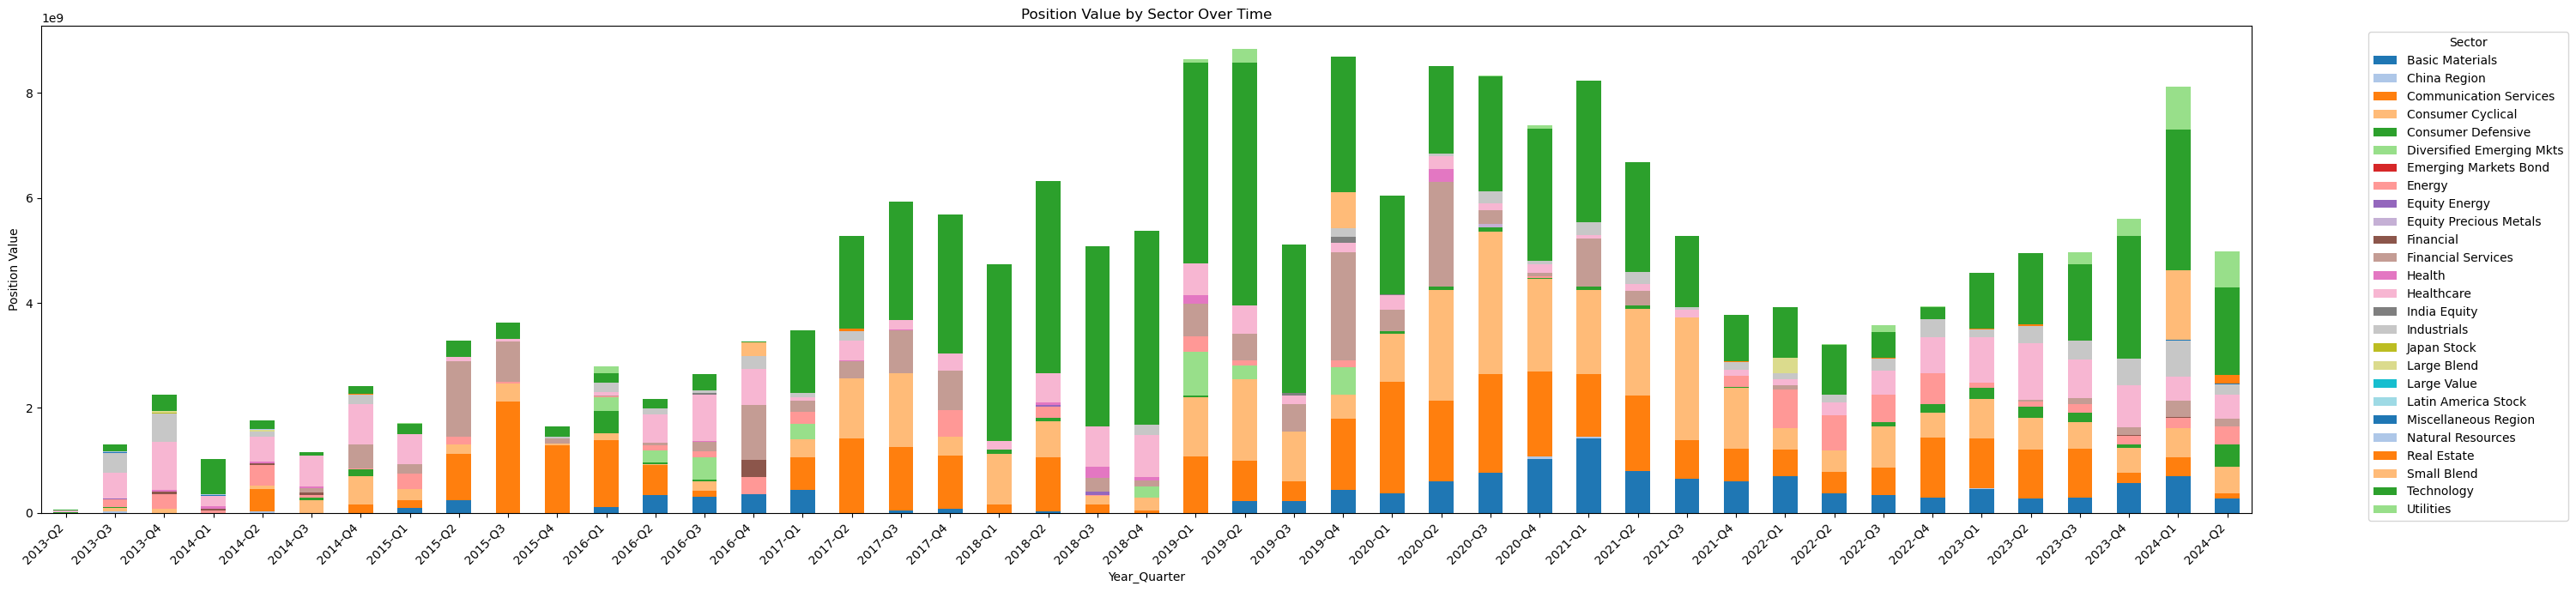

In [154]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Stanley_Druckenmiller"].groupby(["Year_Quarter", "Sector"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = plt.get_cmap('tab20').colors

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Position Value (Billions $)')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

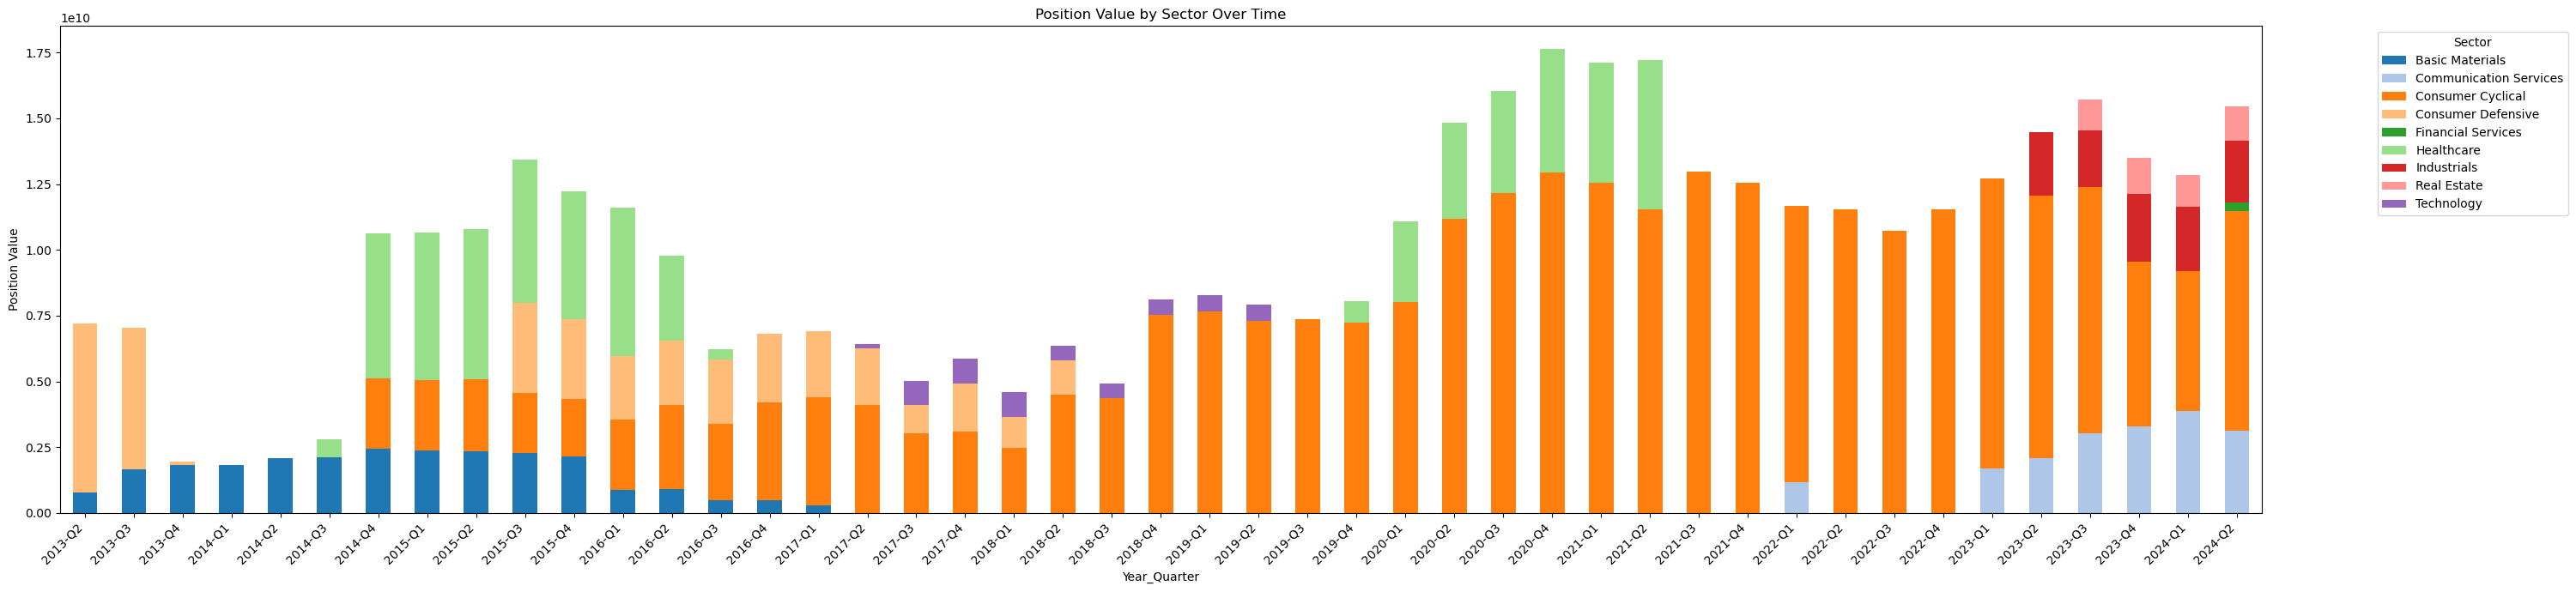

In [155]:
# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Bill_Ackman"].groupby(["Year_Quarter", "Sector"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = plt.get_cmap('tab20').colors

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

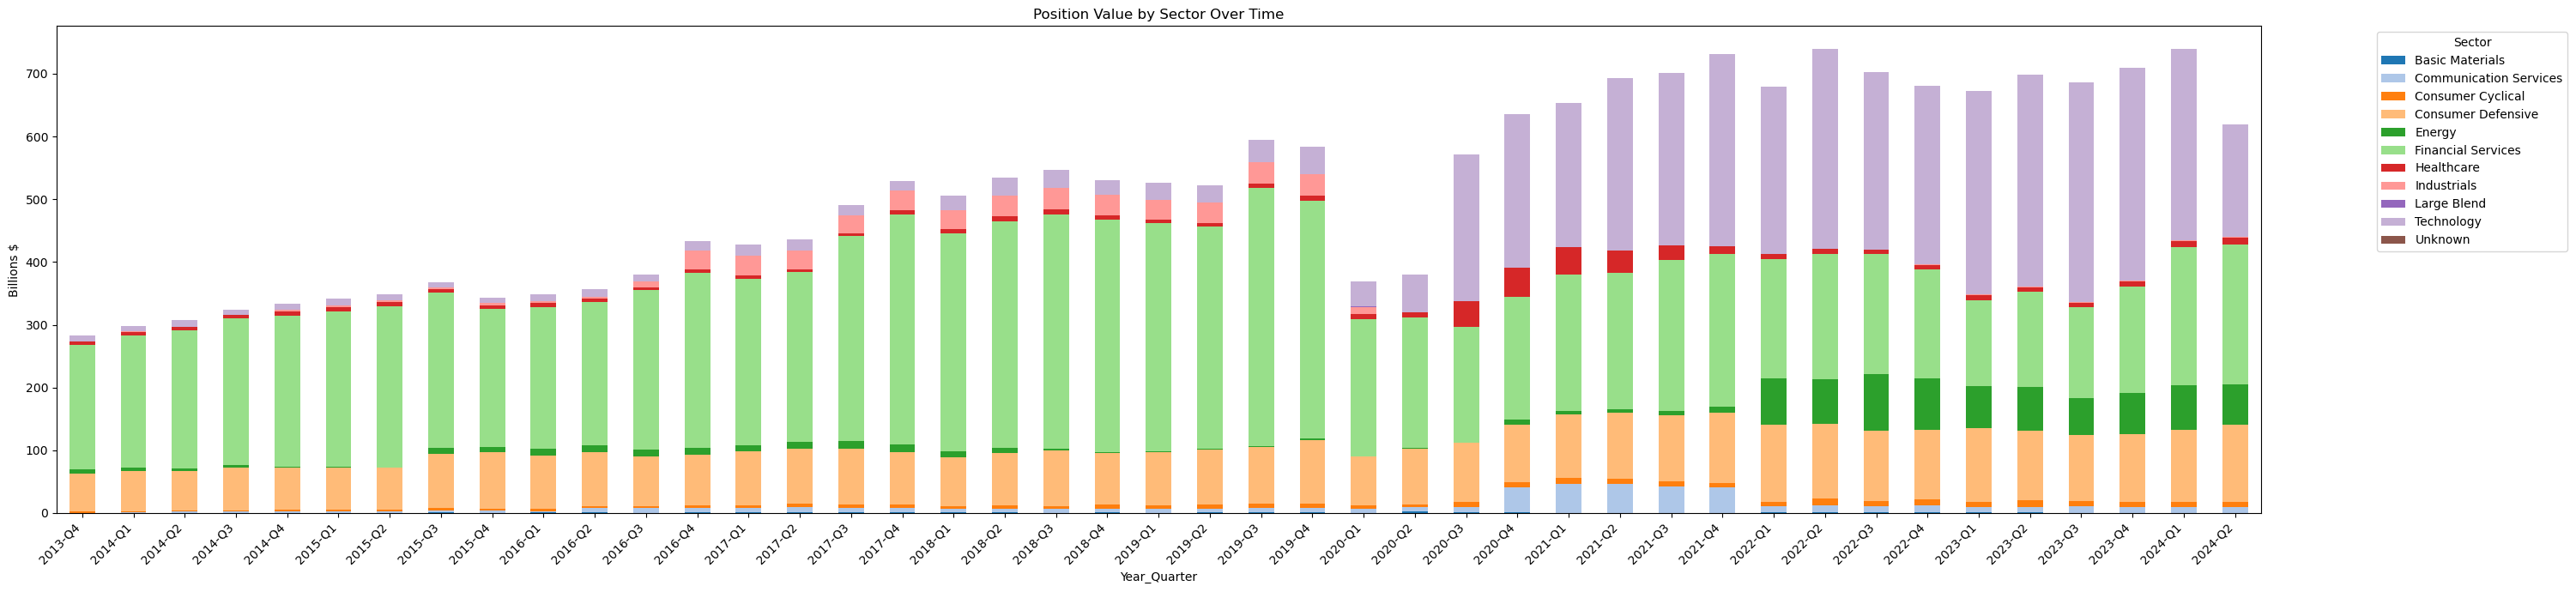

In [168]:

# Assuming holdings_data["Stanley_Druckenmiller"] is already loaded as a DataFrame
df = holdings_data["Warren_Buffet"].groupby(["Year_Quarter", "Sector"])["Position Value"].sum().reset_index()

# Pivot the table to get sectors as columns
pivot_df = df.pivot(index='Year_Quarter', columns='Sector', values='Position Value').fillna(0)

# Create a color map with distinct colors
colors = plt.get_cmap('tab20').colors

# Plot the stacked bar chart with distinct colors
pivot_df.plot(kind='bar', stacked=True, figsize=(30, 7), color=colors)

plt.title('Position Value by Sector Over Time')
plt.xlabel('Year_Quarter')
plt.ylabel('Billions $')
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')

def billions_formatter(x, pos):
    return f"{x // 1e9:.0f}"
plt.gca().yaxis.set_major_formatter(FuncFormatter(billions_formatter))

plt.tight_layout()
plt.show()

In [147]:
df["Sector"].unique()

array(['Basic Materials', 'China Region', 'Communication Services',
       'Consumer Cyclical', 'Consumer Defensive',
       'Diversified Emerging Mkts', 'Emerging Markets Bond', 'Energy',
       'Equity Energy', 'Equity Precious Metals', 'Financial',
       'Financial Services', 'Health', 'Healthcare', 'India Equity',
       'Industrials', 'Japan Stock', 'Large Blend', 'Large Value',
       'Latin America Stock', 'Miscellaneous Region', 'Natural Resources',
       'Real Estate', 'Small Blend', 'Technology', 'Utilities'],
      dtype=object)

In [149]:
df[df["Cumulative_Percentage"] >= 10]["Sector"].unique()

array(['Consumer Defensive', 'Diversified Emerging Mkts',
       'Emerging Markets Bond', 'Energy', 'Equity Energy',
       'Equity Precious Metals', 'Financial', 'Financial Services',
       'Health', 'Healthcare', 'India Equity', 'Industrials',
       'Japan Stock', 'Large Blend', 'Large Value', 'Latin America Stock',
       'Miscellaneous Region', 'Natural Resources', 'Real Estate',
       'Small Blend', 'Technology', 'Utilities', 'Communication Services',
       'Consumer Cyclical', 'Basic Materials', 'China Region'],
      dtype=object)

In [151]:
ticker_data = yf.Ticker("AAPL")
dividends = ticker_data.dividends

# Print the dividend data
print(dividends)

Date
1987-05-11 00:00:00-04:00    0.000536
1987-08-10 00:00:00-04:00    0.000536
1987-11-17 00:00:00-05:00    0.000714
1988-02-12 00:00:00-05:00    0.000714
1988-05-16 00:00:00-04:00    0.000714
                               ...   
2023-08-11 00:00:00-04:00    0.240000
2023-11-10 00:00:00-05:00    0.240000
2024-02-09 00:00:00-05:00    0.240000
2024-05-10 00:00:00-04:00    0.250000
2024-08-12 00:00:00-04:00    0.250000
Name: Dividends, Length: 84, dtype: float64


In [152]:
dfs["Stanley_Druckenmiller"]

,Unnamed: 0,NAME OF ISSUER,CUSIP,CALL,2024-08-14,2024-05-15,2024-02-14,2023-11-14,2023-08-14,2023-05-15,...,2015-08-14,2015-05-15,2015-02-12,2014-11-14,2014-08-14,2014-05-14,2014-02-14,2013-11-14,2013-08-14,SYMBOL
0,13,Coupang Inc,22266T109,NaN,10971140.0,22459850.0,22914940.0,20903865.0,20903865.0,20283765.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CPNG
1,29,Kinder Morgan Inc Del,49456B101,NaN,6753165.0,3880500.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,KMI
2,63,Zoominfo Technologies Inc,98980F104,NaN,5881906.0,5881906.0,924100.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ZI
3,12,Coherent Corp,19247G107,NaN,3589540.0,2525070.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,COHR
4,59,Vistra Corp,92840M102,NaN,2625231.0,2625231.0,2385061.0,1988561.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,VST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,276,Carnival Corp,143658300,Call,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCL
700,277,Disney Walt Co,254687106,Call,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DIS
701,278,Las Vegas Sands Corp,517834107,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LVS
702,279,Qualcomm Inc,747525103,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,QCOM
